In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
custom_data = 1

In [4]:
# move to ashok hw directory
if not custom_data:
  %cd drive/MyDrive/Memorial_SourceImages
else:
  %cd drive/MyDrive/Ashok_Hw1_Part2_Data
  !unzip sony6300
  %cd sony6300

/content/drive/MyDrive/Ashok_Hw1_Part2_Data
Archive:  sony6300.zip
replace sony6300/DSC_0259.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content/drive/MyDrive/Ashok_Hw1_Part2_Data/sony6300


# HDR Image from Varying Exposure Images

## Part 1
The goal of this homework is to implement an HDR algorithm that takes in a series of low dynamic range images and outputs a single HDR image. To display the HDR image you will have to implement a tonemapping algorithm to recast the data between [0,255].

1. First load in images at various exposures and their corresponding exposure times
2. Compute function that applies the inverse of the camera response function
3. Recover HDR radiance map of the scene
4. Implement tonemapping algorithm
5. Try out algorithm on other dataset

In [5]:
# Import methods
# Import necessary packages
import numpy as np
import os
import cv2
import sys
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from zipfile import ZipFile
from PIL import Image
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy import ndimage
import skimage.io as io
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral

In [6]:
## Helper functions

VISUALIZE = True

def imshow(img, strTitle="", cbar=False):
    if not VISUALIZE:
        return
    plt.figure()
    plt.imshow(img)#, cmap='gray')
    plt.title(strTitle)
    if cbar:
        plt.colorbar()

def subplots(*args):
    '''
    example:
    subplots([img1, "title1"], [img2, "title2"], ...)
    or
    subplots(img1, img2, ...)
    '''
    fig, axes = plt.subplots(1, len(args), sharey=True, figsize=(15,15))
    for i, x in enumerate(args):
        try:
            img = x[0]
            strTitle = x[1]+""
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(strTitle)
        except:
            axes[i].imshow(x, cmap='gray')
    plt.show()

def imshowFT(x):
    plt.figure()
    plt.imshow(np.log(np.abs(x)+1))
    plt.colorbar()

def normalize(x):
    return (x-np.min(x))/(np.max(x) - np.min(x))

In [7]:
# os.chdir('/content')

# Load in LDR Images

In [8]:
# # unzip the file of images
# file_name = '/content/Memorial_SourceImages.zip'

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

Load in the LDR images and create image stack

## run if using normal dataset

In [9]:
# !pwd
# !ls

In [10]:
# load in a subset of the images in the folder
if not custom_data:
  folder_dir = './'
  dir_all = os.listdir(folder_dir)
  print(dir_all)
  dir_png= []

  for images in os.listdir(folder_dir):
      # check if the image ends with png
      if (images.endswith(".png")):
          dir_png.append(images)

  # sort in ascending order
  dir_png.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
  print(dir_png)
  rawImg  =np.zeros((768,512,3,16)).astype(np.uint8)
  # rawImg = np.zeros((768//2,512//2,3,16)).astype(np.uint8)
  for ii in range(16):
    tmp = cv2.imread(os.path.join(folder_dir, dir_png[ii]))
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    # tmp = cv2.resize(tmp,[int(512/2),int(768/2)],interpolation = cv2.INTER_AREA)
    rawImg[:,:,:,ii] = tmp

Print metadata about raw images and exposure times

In [11]:
if not custom_data:
  exposure_time = 1 /np.array([0.03125,0.0625,0.125,0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0]) # taken from dataset textfile
  log_exposure_time = np.log(exposure_time)
  print(rawImg.shape) # should be [ DimX DimY 3 Num_Images]
  print(rawImg.dtype) # raw images should be uint8
  print(exposure_time.shape) # should be [Num_Images,]

Crop the registered images to remove boarder effects (solid blue pixels)

In [12]:
if not custom_data:
  rawImg = rawImg[30:-30,30:-30,:,:]

Plot the images in a grid

In [13]:
if not custom_data:
  idx = 1
  m_plots = 4
  n_plots = 4
  plt.figure(figsize=(12,24)) # If you load a different dataset please adapt the size so that it looks good

  plt.suptitle("Images " + folder_dir,fontsize=20)
  for k in range(rawImg.shape[3]):
      plt.subplot(m_plots,n_plots,idx);
      idx = idx + 1
      plt.imshow(rawImg[:,:,:,k])
      plt.title(exposure_time[k])
  plt.tight_layout()

## run if using custom data

In [14]:
if custom_data:
  # load in a subset of the images in the folder
  folder_dir = '.'
  dir_all = os.listdir(folder_dir)
  print(dir_all)
  dir_png= []

  for images in os.listdir(folder_dir):
      # check if the image ends with png
      if (images.endswith(".JPG")):
          dir_png.append(images)

  # sort in ascending order
  dir_png.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
  print(dir_png)


['DSC_0259.JPG', 'DSC_0261.JPG', 'DSC_0266.JPG', 'DSC_0267.JPG', 'DSC09547.JPG', 'DSC09548.JPG', 'DSC09549.JPG', 'DSC09550.JPG', 'DSC09551.JPG', 'DSC09552.JPG', 'DSC09553.JPG', 'DSC09554.JPG', 'DSC09555.JPG', 'DSC09556.JPG', 'DSC09557.JPG', 'DSC09558.JPG', 'DSC09559.JPG', 'DSC09560.JPG', 'DSC09561.JPG', 'DSC09562.JPG', 'DSC09563.JPG', 'DSC09564.JPG', 'DSC09565.JPG', 'DSC09566.JPG', 'DSC09567.JPG', 'DSC09568.JPG', 'DSC09569.JPG', 'DSC09570.JPG', 'DSC09571.JPG', 'DSC09572.JPG', 'DSC09573.JPG', 'DSC09574.JPG', 'DSC09575.JPG', 'DSC09576.JPG', 'DSC09577.JPG', 'DSC09578.JPG', 'DSC09579.JPG', 'DSC09580.JPG', 'DSC09581.JPG', 'DSC09582.JPG', 'DSC09583.JPG', 'DSC09584.JPG', 'DSC09585.JPG', 'DSC09586.JPG', 'DSC09587.JPG', 'DSC09588.JPG', 'DSC09589.JPG', 'DSC09590.JPG', 'DSC09591.JPG', 'DSC09593.JPG', 'DSC09592.JPG', 'DSC09594.JPG', 'DSC09596.JPG', 'DSC09595.JPG', 'DSC09598.JPG', 'DSC09597.JPG', 'DSC09599.JPG', 'DSC09600.JPG', 'DSC09601.JPG', 'DSC09602.JPG', 'DSC09605.JPG', 'DSC09603.JPG', 'DSC096

In [15]:
len(dir_png)

295

In [66]:
if custom_data:
  rawImg  =np.zeros((3376//8,6000//8,3,41-4)).astype(np.uint8) # should be 41
  # rawImg = np.zeros((768//2,512//2,3,16)).astype(np.uint8)
  for ii in range(0, 37):
    tmp = cv2.imread(os.path.join(folder_dir, dir_png[ii+9]))
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    tmp = cv2.resize(tmp,[int(6000/8),int(3376/8)],interpolation = cv2.INTER_AREA)
    rawImg[:,:,:,ii] = tmp

In [67]:
if custom_data:
  exposure_time = 1/np.array([2500, 2000, 1600, 1250, 1000, 800, 640, 500, 400, 320, 250, 200, 160, 100, 80, 60, 50, 40, 30, 25, 20, 15, 13, 10, 8, 6, 5, 4, 3, 0.4, 0.5, 0.6, 0.8, 1, 1.3, 1.6, 2])
  log_exposure_time = np.log(exposure_time)
  print(rawImg.shape) # should be [ DimX DimY 3 Num_Images]
  print(rawImg.dtype) # raw images should be uint8
  print(exposure_time.shape) # should be [Num_Images,]

(422, 750, 3, 37)
uint8
(37,)


# Solve for the Inverse Camera Repsonse Function
The camera response function (CRF) models how the camera nonlinearly maps scene radiance to pixel intensity values. Here we will estimate the camera response function for each color channel and use it to help us merge the LDR images into a HDR image.

We can model the intensity $Z$ measure by the $i^{th}$ pixel during the $j^{th}$ exposure as:
\begin{equation}
Z[i,j] = f(E[i] \cdot T[j]), \quad (1)
\end{equation}
where $E[i]$ is the actual irradiance incident on the $i^{th}$ pixel, $T[j]$ is the exposure time of the $j^{th}$ captured image, and $f$ is the camera response function that maps irradiance values at different camera exposures to digital numbers (usually in the range 0-255).

If we assume the function $f$ is monotonic then its inverse $f^{-1}$ is well defined. Specifically, we declare $g(x) = ln(f^{-1}(x))$, we can write,
\begin{equation}
g(Z[i,j]) = ln(E[i]) + ln(T[j]). \quad (2)
\end{equation}

Your first task is to implement the method introduced by Debevec et al. [1] to recover the repsonse curve $g(Z)$ for values in the range $[0,255]$.

IMPORTANT!!! Do not use all the pixels in the images to solve for the response curve. This will be extremely slow. Instead, think about how many pixels you would need to make the system of equations sufficiently overdetermined (i.e. how many unknowns do you have versus measurements).

In [68]:
# def gsolve(Z,T,ll): # this is the method from the slides, somehow is a little off
#   '''
#   TODO:

#   This function solves for the natural log inverse of the camera repsonse function
#   The function maps log (irradiance * exposure time) to pixel intensity.

#   Inputs:
#   Z - measured pixel intensities
#   T - log exposure times
#   ll - smoothness regularization parameter

#   Outputs:
#   g - the log inverse camera response function
#   lE - log scene irradiance of the image

#   Hints on setting up code:
#   1) define linear matrix A to hold system of equations and b to hold measurements
#   2) populate rows of A with data-fitting equations and fill in b
#   3) fix the camera response curve by setting the middle value to 0 (white balance)
#   4)populate rows of A with smoothness constraint equations
#   '''
#   # assume that we're only passing in the sampled Z's we want to use -- in the form of N * P
#   # set up base matrix to fill
#   N = int(Z.shape[0])
#   P = int(T.shape[0])
#   print(Z.shape, T.shape)
#   A = np.zeros((254+1+N*P, N+256))

#   # establish a Zmid
#   Zmid = (np.max(Z)-np.min(Z))//2

#   # fill in bottom right corner
#   BR = np.zeros((254, 256), dtype=int)
#   # Set the left diagonal to 1
#   np.fill_diagonal(BR[:, :-1], ll)
#   # Set the right diagonal to 1
#   np.fill_diagonal(BR[:, 1:], ll)
#   # Set the central diagonal to -2
#   np.fill_diagonal(BR, -2*ll)
#   print(A[N*P+1:, N:].shape, BR.shape, A.shape)
#   A[N*P+1:, N:] = BR

#   # fill in the Zmid control pixel
#   A[N*P+1, N+Zmid] = 1

#   # fill in the top left part
#   TLid = np.identity(N)*-1
#   TL = np.tile(TLid, P)
#   TL = np.reshape(TL, (N*P, N))
#   A[:N*P, :N] = TL

#   # top right
#   Zflat = Z.flatten()
#   for i in range(Zflat.shape[0]):
#     A[i][N+Zflat[i]] = 1

#   # can either take the log exposure times pre-stacked (N*3) -- but we want to do 1->p N times then add 254 0's
#   y = np.hstack((np.tile(T, N).flatten(), np.zeros((254+1,))))
#   print(A.shape, y.shape)
#   x = np.linalg.lstsq(A, y)
#   lE = x[0][:-256]
#   g = x[0][-256:]
#   # print(x[0])
#   # print()
#   # print(x[1])
#   # print()
#   # print(x[2])
#   # print()
#   # print(x[3])

#   # print(g)
#   # print(lE)

#   return g, lE#g.squeeze(),lE.squeeze()




In [69]:

def gsolve(Z,T,ll, n=256, w = np.ones((256,1))/256, rcond=None):
  '''
  This function solves for the natural log inverse of the camera repsonse function
  The function maps log (irradiance * exposure time) to pixel intensity.

  Inputs:
  Z - measured pixel intensities
  T - log exposure times
  ll - smoothness regularization parameter
  n (optional) - number of pixel values used, make even number if possible

  Outputs:
  g - the log inverse camera response function
  lE - log scene irradiance of the image

  Code:
  1) defines linear matrix A to hold system of equations and b to hold measurements
  2) populates rows of A with data-fitting equations and fills in b
  3) fixes the camera response curve by setting the middle value to 0 (white balance)
  4) populates rows of A with smoothness constraint equations
  '''
  # paper's implementation is flipped compared to campuswire slides
  # copied this straight from pseudocode in paper
  A_row = Z.shape[0] * Z.shape[1] + n + 1 # add 1 to add the g=0 constraint for z=128
  A_col = Z.shape[0] + n

  # initialize Ax = b
  A = np.zeros(shape=(A_row, A_col))
  b = np.zeros(shape=(A_row, 1))

  # fill in the pixel intensity entries on matrix
  # wij is weighting for each pixel where w[Z] is weighting for each intensity from 1-255
  # here we leave them all at 1/256 by default -- even weighting
  # for advanced use cases can use triangle, curve, gauss, etc.
  k = 0
  for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
      wij = w[int(Z[i, j])]
      Z_ind = int(Z[i,j])
      A[k,Z_ind] = wij
      A[k,n+i] = -1 * wij
      b[k] = wij * T[j];
      k+=1

  # set log of middle value to 0: here we add this as just another non-point equation
  A[k,n//2] = 1;
  k+=1;

  # smoothness constancy constraint
  # add the 1, -2, 1 * ll pattern
  for i in range(n-1):
    A[k,i]=ll*w[i+1]
    A[k,i+1]=-2*ll*w[i+1]
    A[k,i+2]=ll*w[i+1]
    k += 1

  res = np.linalg.lstsq(A, b, rcond=rcond)
  x = res[0]

  # split the output vector and return
  g = x[:n]
  lE = x[n:]

  return g.squeeze(), lE.squeeze()

Create a function to extract samples from the image dataset to use in solving for the camera repsonse function

In [70]:
import numpy.lib.recfunctions as nlr



def create_measured_Z_values(rawImg, numSample= 1000, low = 0, high = 255, viewPlots=False):
    """
    TODO:

    This function will sample a subset of the Z values from the captured images
    dataset. Output of this function will be the input of the gsolve function
    to calculate the camera response curve.
    Note: In order to accelerate the speed of the program,
    DO NOT USE ALL PIXELS IN THE IMAGE!
    In this function, you need to sample some of the pixels
    within the input images randomly. You can sample several hunderd or several
    thousand pixels.

    Input:
        rawImg: m*n*3*k array. m, n is the size of each image, and k is the number of input images.
        numSample: number of sampled pixels. Default is 1000, you can use your own values.
        low: the lowest intensity value to trust before considering the pixel underexposed
        high: the highest intensity value to trust before considering the pixel overexposed
        viewPlots: set true to plot numSample pixel statistics

    Output:
        zValues: numSample*k*3 array. numSample is the number of sampled pixels,
        k is the number of images, and 3 represents RGB channels.
        It's the matrix of pixel values,
    """

    # random sampling

    z_vals = np.zeros(shape=(numSample, 3, rawImg.shape[3]), dtype=int)
    indexlist = np.indices((rawImg.shape[0], rawImg.shape[1])).reshape((2, -1)).T
    rng = np.random.default_rng(8008135)
    rng.shuffle(indexlist)

    successes = 0
    pop_indices = []

    for index in indexlist:
        pixelStackValues = rawImg[index[0], index[1]]
        if low <= np.min(pixelStackValues) and np.max(pixelStackValues) <= high:
            z_vals[successes] = pixelStackValues
            successes += 1
            pop_indices.append(index)
        if successes == numSample:
            break

    if successes < numSample:
        print("Not enough trusted pixels in stack.\n Missing " + str(numSample - successes) + "samples.")

    return [z_vals, pop_indices]




In [71]:
numSample = 1000   # think about how mmany values you need to have a sufficiently overdetermined system of equations?
intensity = create_measured_Z_values(rawImg, numSample, low=0, high=250, viewPlots=True)[0]

print(intensity.shape) #should be [numSample, numImages, 3]

(1000, 3, 37)


[[9.90000e-02 1.80000e-01 4.26000e-01 5.73000e-01 3.78000e-01 5.96000e-01
  8.19000e-01 1.02900e+00 1.47800e+00 2.39300e+00 4.74600e+00 3.86800e+00
  9.58300e+00 6.40200e+00 6.60900e+00 1.08540e+01 1.53600e+01 1.99820e+01
  2.39750e+01 2.87280e+01 3.44640e+01 4.11120e+01 5.10010e+01 5.79070e+01
  6.71340e+01 7.59360e+01 7.54340e+01 8.17790e+01 9.08290e+01 1.02323e+02
  1.15604e+02 1.30165e+02 1.42750e+02 1.50379e+02 1.63977e+02 1.77679e+02
  1.92902e+02]
 [9.90000e-02 1.80000e-01 4.26000e-01 5.59000e-01 3.77000e-01 5.96000e-01
  8.15000e-01 1.01400e+00 1.33900e+00 1.93700e+00 3.18200e+00 3.08600e+00
  6.86100e+00 4.92900e+00 4.70000e+00 7.75500e+00 1.00640e+01 1.41810e+01
  1.73830e+01 2.23450e+01 2.74680e+01 3.33020e+01 4.21500e+01 4.78930e+01
  5.58230e+01 6.41830e+01 6.32940e+01 6.94560e+01 7.84070e+01 8.98470e+01
  1.02399e+02 1.16607e+02 1.28980e+02 1.36620e+02 1.50864e+02 1.65849e+02
  1.82357e+02]
 [9.80000e-02 1.79000e-01 4.27000e-01 5.60000e-01 3.76000e-01 5.65000e-01
  8.1400

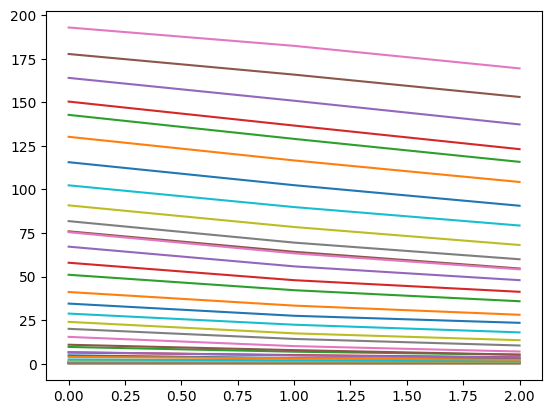

In [72]:
print(intensity.mean(axis=0))
plt.plot(intensity.mean(axis=0))

Run the gsolve function to recover the inverse camera response function

In [73]:
'''
TODO:
Plot the response curve g() for each color channel and in the same plot add the
exposure values used to estimate g() for each color channel.
'''
low = 12 # after inspection, lowest value is around 12
high = 255
n = high - low + 1
numSample=1000
intensity, indices = create_measured_Z_values(rawImg, numSample, low=low, high=high, viewPlots=True)
pixelValuesAxis = np.arange(low, high+1)
# plt.plot(intensity.mean(axis=0)[0, :], 'r')
# plt.plot(intensity.mean(axis=0)[1, :], 'g')
# plt.plot(intensity.mean(axis=0)[2, :], 'b')

print(n)
print("# of erroneous/blank indices generated: " + str(np.count_nonzero(indices==0)))
print(len(pixelValuesAxis))

244
# of erroneous/blank indices generated: 0
244


In [74]:
ll = 1000
solveG = np.ones((256,3))
log_exposure = np.zeros((numSample,3))

solveG[0, :] = 128 # also from paper -- do this to get the middle intensity = 0 constraint

for k in range(3):
    solveG[:, k], log_exposure[:, k] = gsolve(intensity[:,k,:], log_exposure_time, ll, n=256, rcond=None)


In [75]:
lE_sample = np.zeros((intensity.shape))
for i in range(intensity.shape[1]):
  lE_sample[:,:,i] = log_exposure_time[i] + log_exposure

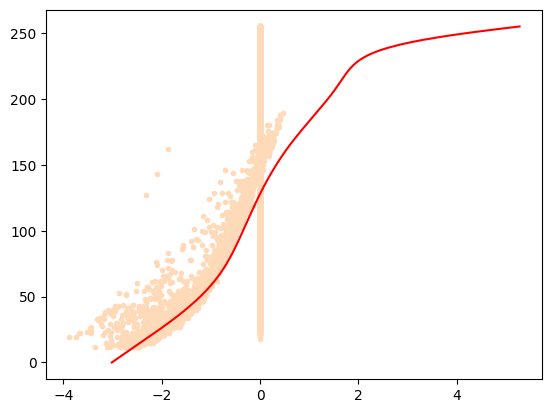

In [76]:
chan = 0
plt.plot(np.ndarray.flatten(lE_sample[:,chan,:]), np.ndarray.flatten(intensity[:,chan,:]), '.',color="peachpuff")
plt.plot(solveG[:,0].squeeze(), np.linspace(0,255,256),'red')

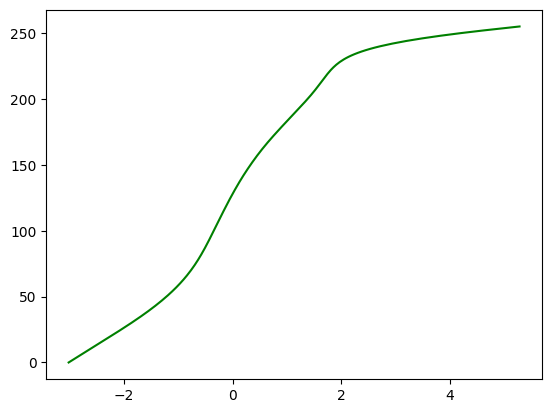

In [77]:
plt.plot(solveG[:,0].squeeze(), np.linspace(0,255,256),'green')


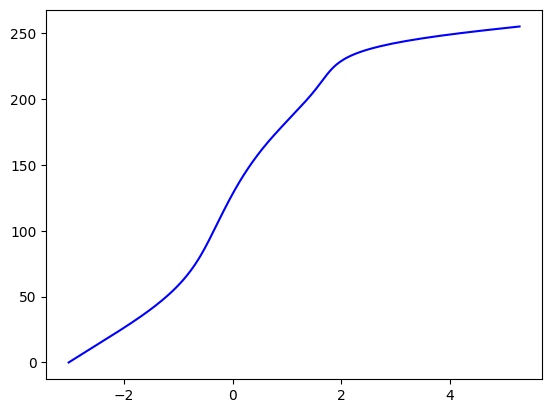

In [78]:
plt.plot(solveG[:,0].squeeze(), np.linspace(0,255,256),'blue')

In [79]:
print(solveG.shape) # should be (256,3)
print(log_exposure.shape) # should be (numSample, 3)

(256, 3)
(1000, 3)


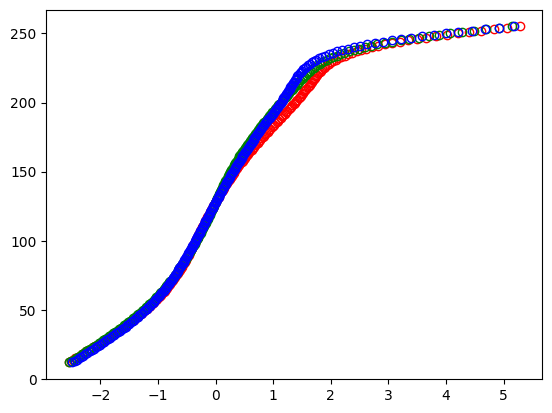

In [80]:
plt.plot(solveG[low:high+1, 0], pixelValuesAxis, 'ro', fillstyle='none')

plt.plot(solveG[low:high+1, 1], pixelValuesAxis, 'go', fillstyle='none')

plt.plot(solveG[low:high+1, 2], pixelValuesAxis, 'bo', fillstyle='none')

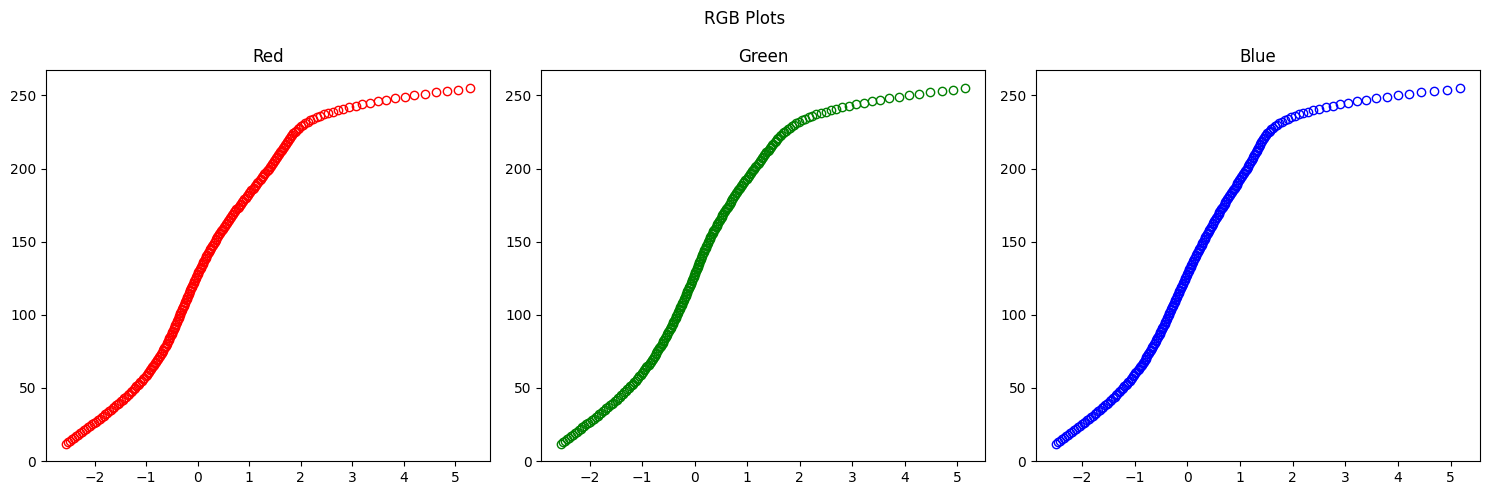

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(solveG[low:high+1, 0], pixelValuesAxis, 'ro', fillstyle='none')
axes[0].set_title("Red")

axes[1].plot(solveG[low:high+1, 1], pixelValuesAxis, 'go', fillstyle='none')
axes[1].set_title("Green")

axes[2].plot(solveG[low:high+1, 2], pixelValuesAxis, 'bo', fillstyle='none')
axes[2].set_title("Blue")

fig.suptitle('RGB Plots')
plt.tight_layout()
plt.show()

# Recover the HDR radiance map of the scene
Once you have recovered the camera response curve you are ready to recover a radiance image from your sequence of exposures. You can recover the radiance map using the following equation:
\begin{equation}
ln(E[i]) = \frac{\frac{1}{P}\sum_{j=1}^{P} w(Z[i,j])(g(Z[i,j]) - ln(T[j]))}{\frac{1}{P}\sum_{j=1}^{P} w(Z[i,j])},
\end{equation}
where $P$ are the number of images that were captured at different exposures

In [82]:
def get_log_radiance(rawImg, log_exposure_time, solveG, weighting_function=np.array(range(256))):
    '''
    TODO
    '''
    # inputs are H*W*3*P, P*3, 256*3
    # output should be N*3
    N = rawImg.shape[0]*rawImg.shape[1]
    log_radiance = np.zeros((N, 3))

    rawImgN = np.reshape(rawImg, (N, 3, -1))
    P = log_exposure_time.shape[0]
    for chan in range(3):
      weighted_z = np.zeros((rawImgN[:, 0, :].shape)) # N * 3 * P
      for i in range(N):
        for j in range(rawImgN.shape[2]):
          weighted_z[i][j] = weighting_function[rawImgN[i][chan][j]]

      mapped_z = np.zeros((weighted_z.shape))
      for i in range(mapped_z.shape[0]):
        for j in range(mapped_z.shape[1]):
          mapped_z[i][j] = solveG[rawImgN[i][chan][j]][chan] - log_exposure_time[j]

      log_radiance[:, chan] = (np.sum(np.multiply(weighted_z, mapped_z), 1)/P) / (np.sum(weighted_z, 1)/P)

    return np.reshape(log_radiance, [rawImg.shape[i] for i in [0, 1, 2]])

In [83]:
solveG.shape

(256, 3)

In [84]:
rawImg.shape

(422, 750, 3, 37)

In [85]:
log_exposure_time.shape

(37,)

In [86]:
log_radiance = get_log_radiance(rawImg,log_exposure_time,solveG)
print('Log Radiance Shape: ', log_radiance.shape)

Log Radiance Shape:  (422, 750, 3)


In [87]:
print(log_radiance)

[[[ 2.55552382  2.55433026  2.33369869]
  [ 2.59399426  2.58041529  2.34847148]
  [ 2.63233726  2.60472884  2.35386818]
  ...
  [-0.53503398 -0.96783645 -1.27579488]
  [-0.50224525 -0.94437958 -1.21926124]
  [-0.53266532 -0.96253847 -1.25684734]]

 [[ 2.67224529  2.65796156  2.43798898]
  [ 2.6305117   2.6138651   2.36744588]
  [ 2.64594902  2.61888748  2.38692224]
  ...
  [-0.53748513 -0.95386055 -1.27082226]
  [-0.51859256 -0.93564648 -1.2428312 ]
  [-0.52797216 -0.95250915 -1.26325224]]

 [[ 2.71627876  2.66025343  2.46037366]
  [ 2.68526399  2.66487094  2.4221111 ]
  [ 2.6511959   2.62295948  2.37364389]
  ...
  [-0.5142246  -0.88842508 -1.17818571]
  [-0.49350403 -0.87303537 -1.14322867]
  [-0.4982944  -0.87710385 -1.15811473]]

 ...

 [[ 1.36510126  0.88851924  0.71579164]
  [ 1.27311361  0.78764159  0.61465976]
  [ 1.28476569  0.78992424  0.6134321 ]
  ...
  [ 0.66788694  0.32959084 -0.02242985]
  [ 0.64371792  0.30531136 -0.04479633]
  [ 0.62243273  0.28781911 -0.06213795]]

 [

Text(0.5, 1.0, 'Blue Channel: Values in log scale')

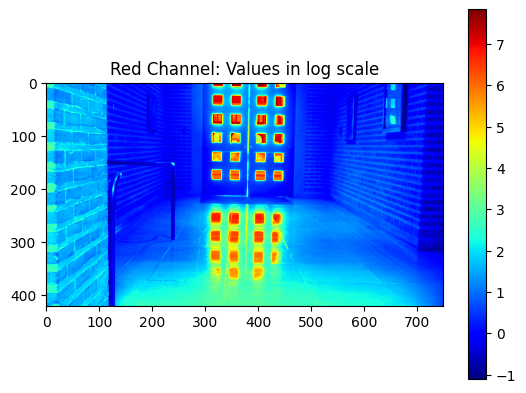

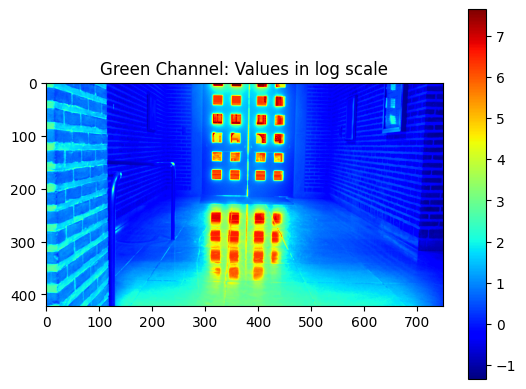

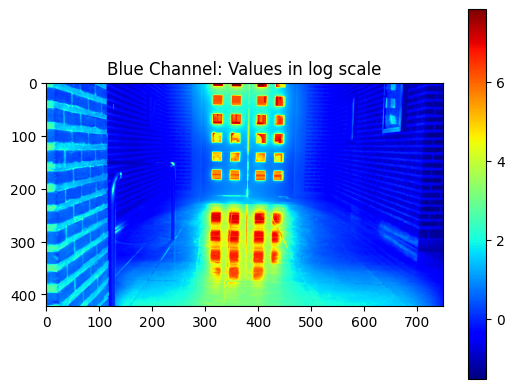

In [88]:
cmapName = 'jet' #'plasma'
plt.figure()
plt.imshow(log_radiance[:,:,0],cmap=cmapName)
plt.colorbar()
plt.title('Red Channel: Values in log scale')

plt.figure()
plt.imshow(log_radiance[:,:,1],cmap=cmapName)
plt.colorbar()
plt.title('Green Channel: Values in log scale')

plt.figure()
plt.imshow(log_radiance[:,:,2],cmap=cmapName)
plt.colorbar()
plt.title('Blue Channel: Values in log scale')

# Tonemapping
Now that the radiance map has been recovered for all color channels the dynamic range of the scene is much larger than the dynamic range that electronic displays can handle to view the image. You will now apply a simple global tone-mapping algorithm to your radiance image so that you can visualize the scene in a perceptually compelling way. You will implement gamma correction tone mapping algorithm.

## Scale Brightness
In this section, you need to convert from log radiance to radiance and implement a function that normalizes the radiance map to vlaues between 0 and 1 using the following equation (min-max normalization):
\begin{equation}
E_{norm}[i] = \frac{E[i] - E_{min}}{E_{max} - E_{min}}
\end{equation}

Note you will need to normalize each color channel independently to get the color balance correct. Thus, for each color channel (R,G,B) of the recovered radiance map $E[i] = R[i],G[i],B[i]$ compute:
\begin{align}
R_{norm}[i] &= \frac{R[i] - R_{min}}{R_{max} - R_{min}} \\
G_{norm}[i] &= \frac{G[i] - G_{min}}{G_{max} - G_{min}}\\
B_{norm}[i] &= \frac{B[i] - B_{min}}{B_{max} - B_{min}}
\end{align}

In [89]:
def tonemapping_scaleBrightness(radiance):
    '''
    TODO
    '''
    # radiance has dimensions h, w, 3
    radiance_norm = np.zeros(radiance.shape)
    for chan in range(radiance.shape[2]):
      chan_min = np.min(radiance[:,:,chan])
      chan_max = np.max(radiance[:,:,chan])
      print(['red', 'green', 'blue'][chan], chan_min, chan_max)
      radiance_norm[:,:,chan] = (radiance[:, :, chan] - chan_min)/(chan_max - chan_min)
    return radiance_norm

In [90]:
#!!! convert from log_radiance to radiance !!!
radiance = np.exp(log_radiance)
# print(radiance)
radiance_norm = tonemapping_scaleBrightness(radiance)

print(radiance_norm.shape)  # Should be (numX, numY, 3)
print(radiance_norm.dtype)  # Should be float64

red 0.32927938580761307 2524.395027080827
green 0.2616876655866308 2087.2076455641627
blue 0.22102603780885005 2491.6121327070164
(422, 750, 3)
float64


Generate some figures of the normalized color channels to include in your writeup

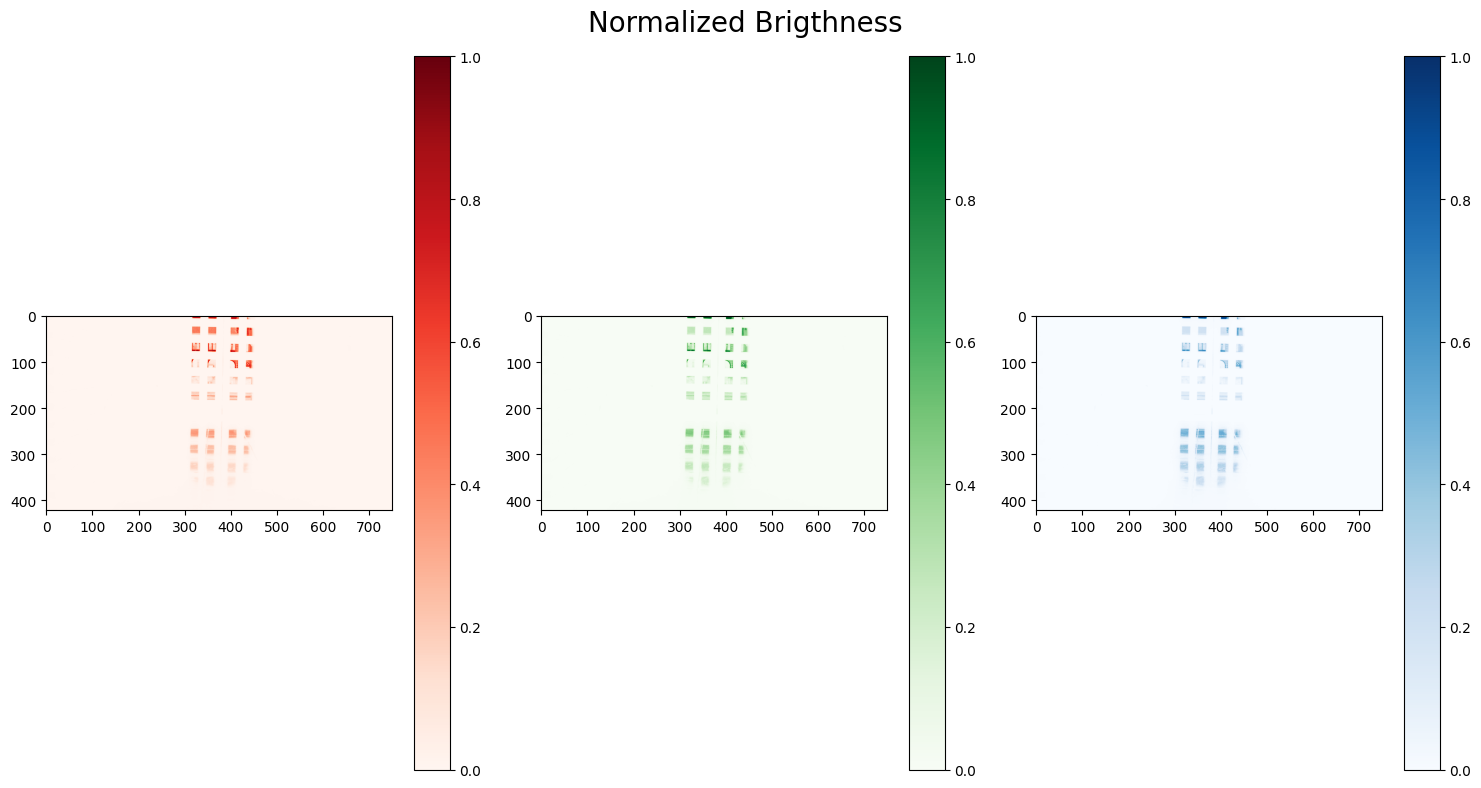

In [91]:
plt.figure(figsize=(15,8))

def plot_3_channels(radiance_normalized,title=""):
    colors = ["Reds","Greens","Blues"]

    plt.suptitle(title,fontsize=20)
    for k in range(3):
        plt.subplot(1,3,k+1)
        plt.imshow(radiance_normalized[:,:,k],cmap=colors[k])
        plt.colorbar()
    plt.tight_layout()

plot_3_channels(radiance_norm,"Normalized Brigthness")

## Gamma Adjustment
Next, apply a gamma curve to the normalized radiance map. To do this simple raise the irradiance of each pixel to the exponent of $\gamma$.
\begin{equation}
E_{gamma}[i] = E[i]_{norm}^{\gamma}
\end{equation}
Play with different values of $\gamma$ and report your findings. Can you find a value of gamma that gives you a visually pleasing HDR result?

In [92]:
def tonemapping_gamma_curve(radiance_norm, gamma= 0.3):
    '''
    TODO:
    This function applys gamma correction as a simple
    global tonemapping algorithm.
    '''
    radiance_gamma = np.power(radiance_norm, gamma)
    return radiance_gamma

(422, 750, 3)
float64


Text(0.5, 1.0, 'HDR Image')

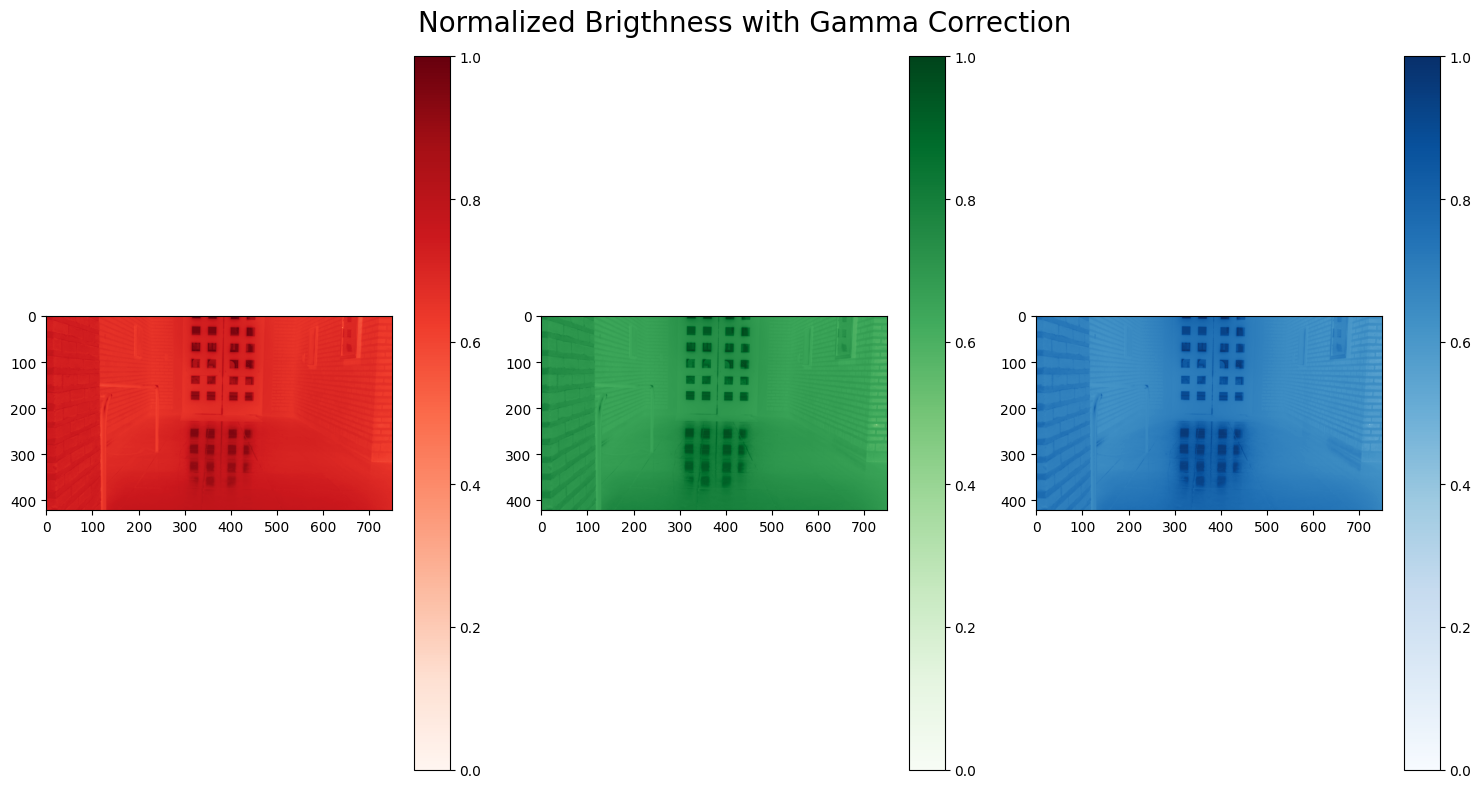

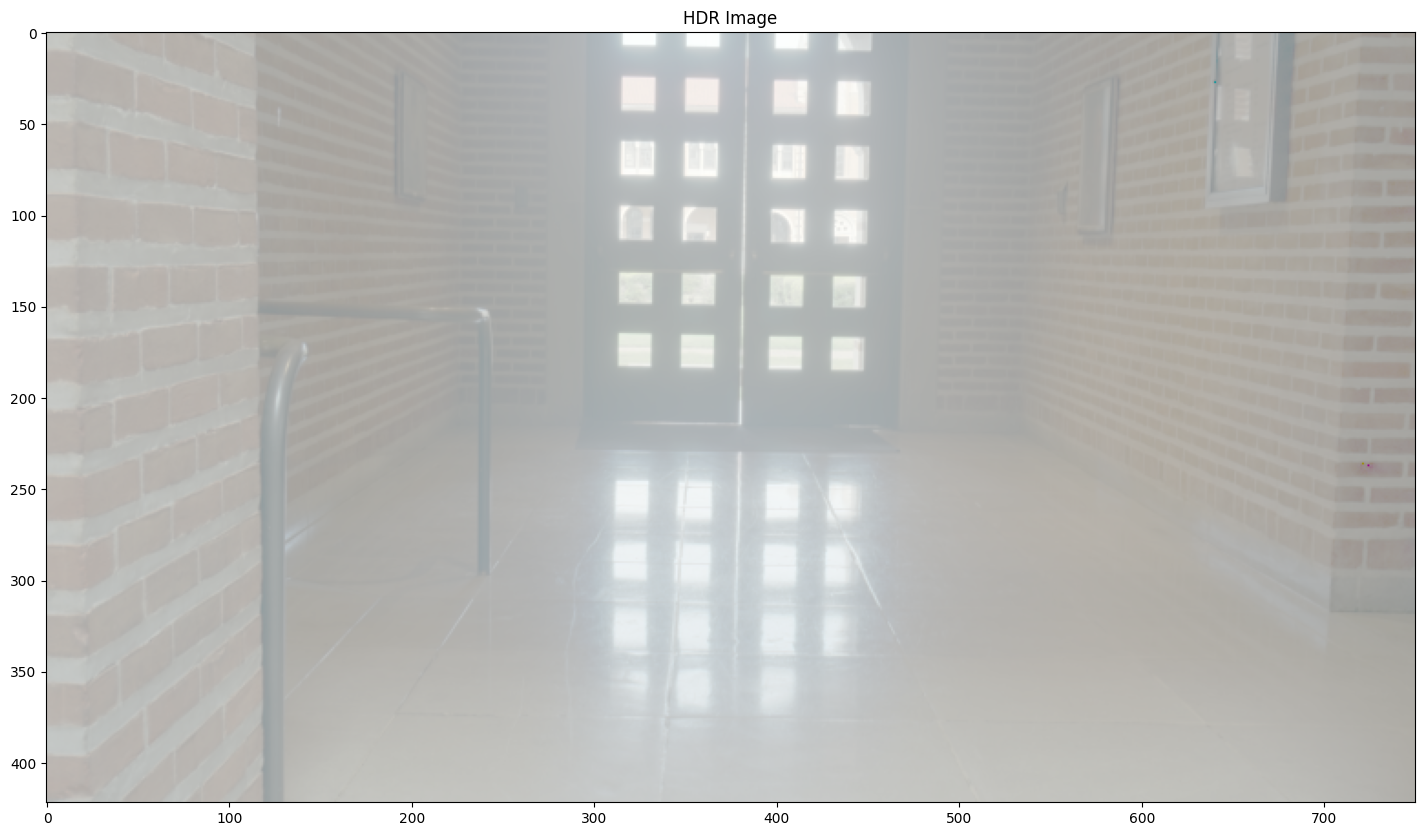

In [93]:
radiance_gamma = tonemapping_gamma_curve(radiance_norm, gamma=0.05)
plt.figure(figsize=(15,8))
plot_3_channels(radiance_gamma,"Normalized Brigthness with Gamma Correction");
print(radiance_gamma.shape) # Should be (numX, numY, 3)
print(radiance_gamma.dtype) # Should be float64

plt.figure(figsize=(20,10));
plt.imshow(radiance_gamma);
plt.title('HDR Image')

# Reinhard Tone Mapping Algorithm
Lastly, you will implement the global tonemapping operator from Erik Reinhard paper "Photographic Tone Reproduction for Digital Images". This tone mapping operator works on the image luminance. So you will need to convert the color radiance image to a luminance radiance image.

Outline of tone mapping algorithm, first convert normalized radiance to luminance
\begin{equation}
L[i] = rgb2luminance(E_{norm}[i])
\end{equation}
Next, we calculate the log average luminance of the radiance,
\begin{equation}
L_{avg} = \exp(\frac{1}{N}\sum_i \ln(\delta + L[i])),
\end{equation}
where $\delta$ is a small value to avoid singularities and the summation is over all pixels in the luminance image. Next scale the image according to,
\begin{equation}
S[i] = \frac{a}{L_{avg}}L[i],
\end{equation}
where $a$ is a parameter ("the key") used to tune the tone mapping for best visual apperance. Next, apply the Reinhard tone mapping operator,
\begin{equation}
L_{tone}[i] = \frac{S[i] \cdot (1 + \frac{S[i]}{S_{max}^2})}{1 + S[i]}.
\end{equation}
Note that, like the gamma mapping, the Reinhard tone mapping operator also maps the radiance values to the range $[0,1]$. Finally, define the scaling operator,
\begin{equation}
M[i] = \frac{L_{tone}[i]}{L[i]},
\end{equation}
and use this operator to scale each of the color channels in the radiance image. If the red, green, and blue channel of the radiance image are R,G, and B, we will form a new HDR image as,
\begin{align}
R_{HDR}[i] &= M[i] \cdot R_{norm}[i]\\
G_{HDR}[i] &= M[i] \cdot G_{norm}[i]\\
B_{HDR}[i] &= M[i] \cdot B_{norm}[i]
\end{align}

In [94]:
def tonemapping_reinhard(radiance, d=0.0001, a =0.18):
  '''
  TODO:
  This function implements the reinhard tone mapping algorithm.
  rgb2gray converts RGB values to grayscale values by forming a weighted
  sum of the R, G, and B components:

  Luminance = 0.2989 * R + 0.5870 * G + 0.1140 * B
  '''
  # radiance is h*w*3
  luminance = 0.2989*radiance[:,:,0] + 0.587*radiance[:,:,1] + 0.114*radiance[:,:,2]
  l_avg = np.exp(np.mean(np.log(d + luminance)))
  S = a/l_avg*luminance
  l_tone = (np.multiply(S, (1+S/np.max(S)**2)))/(1+S)
  M = np.divide(l_tone, luminance)
  print(M.shape)

  radiance_rh = np.zeros(radiance.shape)
  for chan in range(radiance.shape[2]):
    radiance_rh[:,:,chan] = np.multiply(M, radiance[:,:,chan])

  return radiance_rh

In [95]:
radiance_norm.shape

(422, 750, 3)

Plot the resulting Reinhard tone mapping HDR image

(422, 750)


(422, 750, 3)
float64


Text(0.5, 1.0, 'HDR Image')

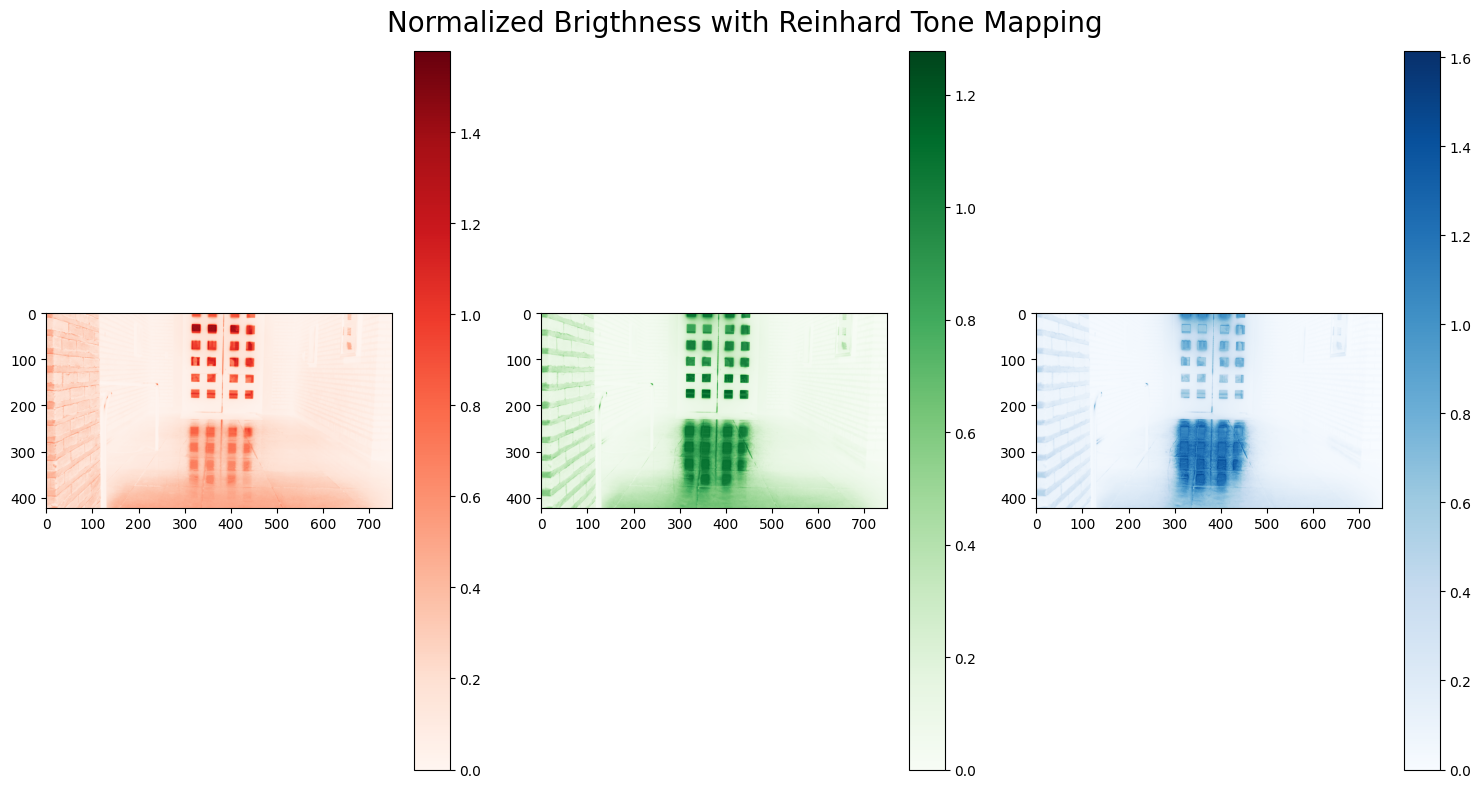

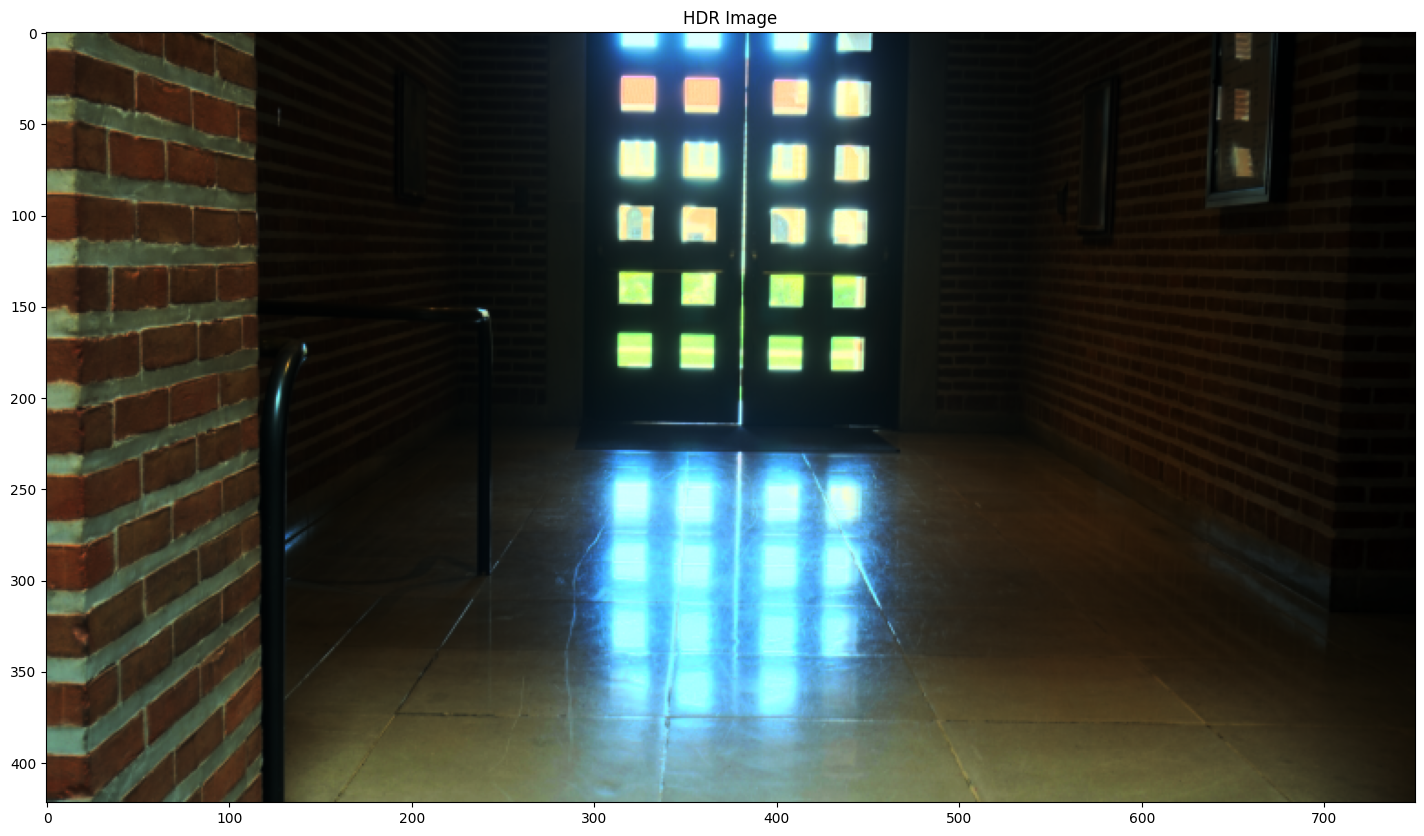

In [96]:
radiance_rh = tonemapping_reinhard(radiance_norm, d=0.0, a= 0.18)
plt.figure(figsize=(15,8))
plot_3_channels(radiance_rh,"Normalized Brigthness with Reinhard Tone Mapping");
print(radiance_rh.shape) # Should be (numX, numY, 3)
print(radiance_rh.dtype) # Should be float64

plt.figure(figsize=(20,10));
plt.imshow(radiance_rh);
plt.title('HDR Image')

# Exposure Fusion
##Part 2

Implement this paper
https://web.stanford.edu/class/cs231m/project-1/exposure-fusion.pdf

This part of the assignment uses the different LDR images to combine into a single high-quality image directly without getting the camera response curve and the irradiance values.
1. Define the quality measures
2. Implement the different fusion techniques (naive, Gaussian, Bilateral)
3. Implemen the Gaussian and Laplacian pyramids and use them for fusion


**NOTE:** These function skeletons are provided as a guidance, but feel free to change the structure or use your own

In [97]:
!pwd
!ls

/content/drive/MyDrive/Ashok_Hw1_Part2_Data/sony6300
DSC_0259.JPG  DSC09586.JPG  DSC09629.JPG  DSC09672.JPG	DSC09715.JPG  DSC09758.JPG  DSC09801.JPG
DSC_0261.JPG  DSC09587.JPG  DSC09630.JPG  DSC09673.JPG	DSC09716.JPG  DSC09759.JPG  DSC09802.JPG
DSC_0266.JPG  DSC09588.JPG  DSC09631.JPG  DSC09674.JPG	DSC09717.JPG  DSC09760.JPG  DSC09803.JPG
DSC_0267.JPG  DSC09589.JPG  DSC09632.JPG  DSC09675.JPG	DSC09718.JPG  DSC09761.JPG  DSC09804.JPG
DSC09547.JPG  DSC09590.JPG  DSC09633.JPG  DSC09676.JPG	DSC09719.JPG  DSC09762.JPG  DSC09805.JPG
DSC09548.JPG  DSC09591.JPG  DSC09634.JPG  DSC09677.JPG	DSC09720.JPG  DSC09763.JPG  DSC09806.JPG
DSC09549.JPG  DSC09592.JPG  DSC09635.JPG  DSC09678.JPG	DSC09721.JPG  DSC09764.JPG  DSC09807.JPG
DSC09550.JPG  DSC09593.JPG  DSC09636.JPG  DSC09679.JPG	DSC09722.JPG  DSC09765.JPG  DSC09808.JPG
DSC09551.JPG  DSC09594.JPG  DSC09637.JPG  DSC09680.JPG	DSC09723.JPG  DSC09766.JPG  DSC09809.JPG
DSC09552.JPG  DSC09595.JPG  DSC09638.JPG  DSC09681.JPG	DSC09724.JPG  DSC09767.JPG  

In [98]:
## Part1: Define the quality measures

# get Contrast C
def getContrast(img):
    # follow formula
    return cv2.Laplacian(np.mean(img, axis=3), cv2.CV_64F)

# get Saturation S
def getSaturation(img):
    # standard deviation
    return np.std(img, axis=3)

# get Well-exposedness E LOL
def getExp(img, sigma=0.2):
    # formula again
    dist = np.exp(-np.power(img - 0.5, 2) / (2 * sigma**2))
    return np.multiply(dist[:,:,:,0], dist[:,:,:,1], dist[:,:,:,2])

In [99]:
## Part2: Fusion

def combineWeights(C, S, E, wc=1, ws=1, we=1):
    return C**wc * S**ws * E**we + 1e-10 # add this term to prevent the summation from being 0 and then inverted

def normalizeWeights(Wkij):
    weights_sum = np.sum((Wkij), axis=0)
    Wkij_norm = Wkij / weights_sum
    return (Wkij_norm - Wkij_norm.min()) / (Wkij_norm.max() - Wkij_norm.min())

def getResult(Wkij, imgs):
    R = np.sum((Wkij[..., None] * imgs), axis=0)
    return R


In [118]:
if not custom_data:
  base_dir = ""
  img1 = io.imread(base_dir+"memorial0061.png")
  img2 = io.imread(base_dir+"memorial0065.png")
  img3 = io.imread(base_dir+"memorial0066.png")
  img4 = io.imread(base_dir+"memorial0068.png")
  img5 = io.imread(base_dir+"memorial0069.png")
  img6 = io.imread(base_dir+"memorial0072.png")

  N = 6
  imgs = np.zeros(np.append(N,img1.shape))
  imgs[0,...] = img1
  imgs[1,...] = img2
  imgs[2,...] = img3
  imgs[3,...] = img4
  imgs[4,...] = img5
  imgs[5,...] = img6
  imgs = imgs/255

  # You could also crop the images as done in part to get rid of blue regions

  subplots(*[imgs[i,...] for i in range(N)])

else:




  N = 6
  imgs = np.zeros(np.append(N,rawImg[:,:,:,0].shape))
  imgs[0,...] = rawImg[:,:,:,0]
  imgs[1,...] = rawImg[:,:,:,7]
  imgs[2,...] = rawImg[:,:,:,14]
  imgs[3,...] = rawImg[:,:,:,21]
  imgs[4,...] = rawImg[:,:,:,28]
  imgs[5,...] = rawImg[:,:,:,35]
  imgs = imgs/255

  # You could also crop the images as done in part to get rid of blue regions
  imgs = imgs[:, 15:-15, 15:-15]
  #subplots(*[imgs[i,...] for i in range(N)])
  imgs.shape


In [119]:
imgs.shape

(6, 392, 720, 3)

In [120]:
if custom_data:
  imgs = np.transpose(imgs, (0, 2, 1, 3))

In [121]:
imgs.shape

(6, 720, 392, 3)

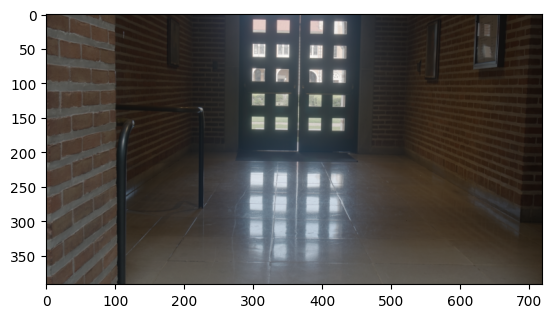

In [132]:
## Complete pipeline

## Method I: Naive combination
C = getContrast(imgs)
S = getSaturation(imgs)
E = getExp(imgs)
Wkij = combineWeights(C,S,E)
Wkij_norm = normalizeWeights(Wkij)
img_naive = getResult(Wkij_norm, imgs)

if custom_data:
  img_naive = np.transpose(img_naive, (1, 0, 2))

imshow(img_naive/np.max(img_naive))

In [133]:
## Method II: Smooth weight map by Gaussian

# pretty simple cv2 method implementation, nothing to say here
def getGaussian(w, sigma):
    w_Gauss = cv2.GaussianBlur(w, (3, 3), sigmaX=sigma, sigmaY=sigma)
    return w_Gauss

sigma = 1 #set sigma here
Wkij_gaussian = getGaussian(Wkij_norm, sigma)
img_gaussian = getResult(Wkij_gaussian, imgs) # get the result after Gaussian filtering the weight maps
if custom_data:
  img_gaussian = np.transpose(img_gaussian, (1, 0, 2))

img_gaussian_norm = (img_gaussian- img_gaussian.min()) / (img_gaussian.max() - img_gaussian.min())

imshow(img_gaussian_norm)


In [135]:
## Method III: Bilateral filtering
Wkij_bilateral = np.zeros_like(Wkij_norm)

# don't worry if this is slightly slow
def getBilateral(w, d=9, sigmaColor=75, sigmaSpace=75):
    w = w.astype(np.float32)
    w_bilateral = np.zeros_like(w)
    for k in range(w.shape[0]):
      w_bilateral[k] = cv2.bilateralFilter(w[k], d, sigmaColor,sigmaSpace)
    return w_bilateral


Wkij_bilateral = getBilateral(Wkij_norm)
img_bilateral = getResult(Wkij_bilateral, imgs)

if custom_data:
  img_bilateral = np.transpose(img_bilateral, (1, 0, 2))


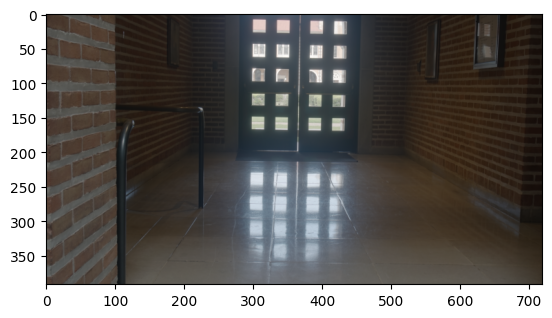

In [137]:
imshow(img_bilateral/np.max(img_bilateral))

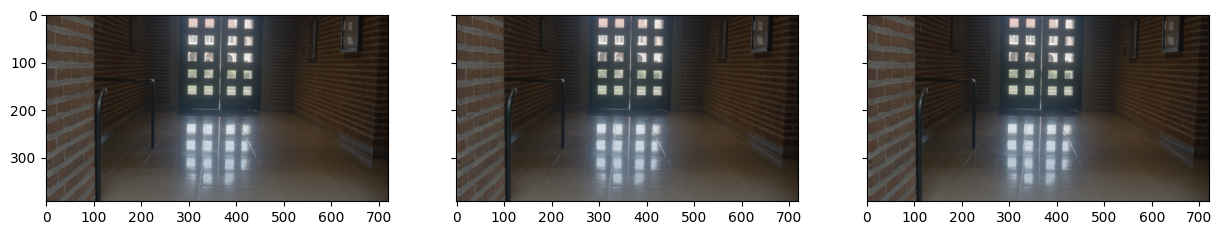

In [125]:
subplots(img_naive/np.max(img_naive), img_gaussian/np.max(img_gaussian), img_bilateral/np.max(img_bilateral))

In [126]:
def getGaussianPyramid(img, numLevels=4, sigma0=1):

  img = np.transpose(img, (1,2,0))
  gausspyr = [img]
  for lvl in range(numLevels-1):
      img = cv2.pyrDown(img)
      gausspyr.append(img)
  return gausspyr


def getLaplacianPyramid(img,  numLevels=4):
  lappyr_RGB = []
  for chan in range(3):
    # grab the gaussian pyramid for every channel, then just pyr up and subtract gaussians to get laplacian
    # we can call this the tower of differences of gaussians, or tower of DoGs for short. WOOF WOOF
    gaussian_img_channel = getGaussianPyramid(img[:,:,:,chan])
    pyramid = [gaussian_img_channel[-1]]

    for level in range(numLevels-1, 0, -1):
      gaussimg = cv2.pyrUp(gaussian_img_channel[level])
      DoG = cv2.subtract(gaussian_img_channel[level-1], gaussimg)
      pyramid.append(DoG)
    lappyr_RGB.append(pyramid[::-1])

  return lappyr_RGB


def getWeightedLaplacianPyramid(gaussian, laplacian, L=4):

    big = []
    for chan in range(3):
      small = []
      for i in range(L):
        temp = gaussian[i]*laplacian[chan][i]
        temp = np.sum(temp, axis=2)
        small.append(temp)
      big.append(small)

    return big

def collapsePyramid(pyramid, L=4):
      result = pyramid[-1]
      # go bottom up thru pyramid
      for i in range(len(pyramid) - 2, -1, -1):
        # upsample and add upwards
        result = cv2.add(cv2.pyrUp(result), pyramid[i])
      return result


In [127]:
# gaussboi
weight_pyramid = getGaussianPyramid(Wkij_norm)
# lappy
lappyramid = getLaplacianPyramid(imgs)
# multiply them
weighted = getWeightedLaplacianPyramid(weight_pyramid, lappyramid)

# get each pyramid
coll_red = collapsePyramid(weighted[0])
coll_green = collapsePyramid(weighted[1])
coll_blue = collapsePyramid(weighted[2])

# stack them back into an RGB image
collapsed = np.dstack((coll_red, coll_green, coll_blue))
if custom_data:
  collapsed = np.transpose(collapsed, (1, 0, 2))
# print(collapsed)
# normalize the pixel values
collapsed_norm = (collapsed-collapsed.min()) / (collapsed.max()-collapsed.min())
plt.imshow(collapsed_norm)

In [128]:
plt.imshow(img_bilateral)

In [129]:
plt.imshow(img_naive)

In [130]:
!pwd

/content/drive/MyDrive/Ashok_Hw1_Part2_Data/sony6300


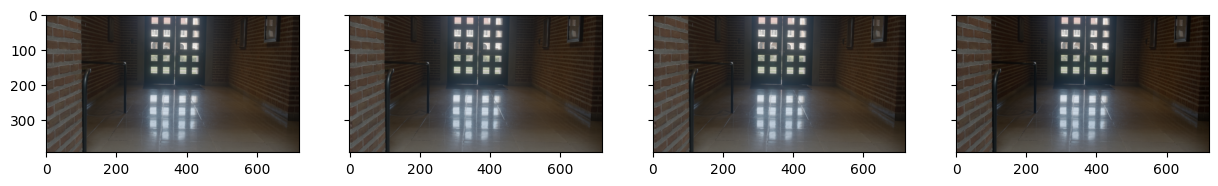

In [131]:
subplots(img_naive/np.max(img_naive), img_gaussian/np.max(img_gaussian), img_bilateral/np.max(img_bilateral), collapsed_norm)